In [1]:
%cd ~/Desktop/my_repos/Predicting-Spotify-Song-Popularity

/home/pysolver33/Desktop/my_repos/Predicting-Spotify-Song-Popularity


In [2]:
%ll

total 28880
drwxr-xr-x 2 pysolver33     4096 Feb  8 20:29  images/
-rw-r--r-- 1 pysolver33    24898 Feb  8 20:29  README.md
-rw-r--r-- 1 pysolver33  3351270 Feb 13 00:10  spotify_data_analysis.ipynb
-rw-r--r-- 1 pysolver33 26178520 Feb  8 09:36 'Spotify Song Data (Full).csv'
drwxr-xr-x 2 pysolver33     4096 Feb 10 19:53  src/


# Objective 
The ultimate goal of this script was to use linear regression
in order to predict a popularity score, using the attributes listed below
as dependent variables.

All columns in this dataset and a full description of each.
Note these descriptions are from Spotify's API website.
    
## Feature definition
- __acousticness__ (float):   
    - A confidence measure from 0.0 to 1.0 of whether the 
    track is acoustic. 1.0 represents high confidence 
    the track is acoustic.

- __danceability__ (float):   
    - Danceability describes how suitable a track is for 
    dancing based on a combination of musical elements 
    including tempo, rhythm stability, beat strength, 
    and overall regularity. A value of 0.0 is least 
    danceable and 1.0 is most danceable.

- __duration_ms__ (int): 
    - The duration of the track in milliseconds.
- __energy__ (float): 
    - Energy is a measure from 0.0 to 1.0 and represents a 
    perceptual measure of intensity and activity. Typically, 
    energetic tracks feel fast, loud, and noisy. For example, 
    death metal has high energy, while a Bach prelude scores low 
    on the scale. Perceptual features contributing to this 
    attribute include dynamic range, perceived loudness, timbre, 
    onset rate, and general entropy.
- __instrumentalness__ (float): 
    - Predicts whether a track contains no vocals. “Ooh” 
    and “aah” sounds are treated as instrumental in this 
    context. Rap or spoken word tracks are clearly “vocal”. 
    The closer the instrumentalness value is to 1.0, the 
    greater likelihood the track contains no vocal content. 
    Values above 0.5 are intended to represent instrumental 
    tracks, but confidence is higher as the value approaches 
    1.0.
- __key__ (int): 
    - The estimated overall key of the track. Integers map to pitches using 
   stanbeats perdard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. 
   If no key was detected, the value is -1.
- __liveness__ (float): 
    - Detects the presence of an audience in the recording. 
    Higher liveness values represent an increased probability that the 
    track was performed live. A value above 0.8 provides strong likelihood 
    that the track is live.
- __loudness__ (float): 
    - The overall loudness of a track in decibels (dB). 
    Loudness values are averaged across the entire track and are useful for comparing 
    relative loudness of tracks. Loudness is the quality of a sound that is the primary 
    psychological correlate of physical strength (amplitude). Values typical range between 
    -60 and 0 db.
- __mode__( int): 
    - Mode indicates the modality (major or minor) of a track, the type of scale 
    from which its melodic content is derived. Major is represented by 1 and minor is 0.
- __speechiness__ (float): 
    - Speechiness detects the presence of spoken words in a track. 
    The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), 
    the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably 
    made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain 
    both music and speech, either in sections or layered, including such cases as rap music. 
    Values below 0.33 most likely represent music and other non-speech-like tracks. 
- __tempo__: 
    - beats per minute
- __valence__ (float): 
    - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by 
    a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks 
    with low valence sound more negative (e.g. sad, depressed, angry).
    popularity - overall popularity score (based on # of clicks) The popularity of the track. The value 
    will be between 0 and 100, with 100 being the most popular.
- time_signature:
    - year

The popularity of a track is a value between 0 and 100, with 100 being the most popular. 
The popularity is calculated by algorithm and is based, in the most part, on the total number of plays 
the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that 
were played a lot in the past.

## Hypothesis
- look at all the normalized data, find correlation, and map/weight normalized data to regression model
- recency bias has large relevance to popularity score


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

### Define Global Variables

In [4]:
### Define Global Variables ###
global objtect_cols
object_cols = ['artist_name', 'track_id', 'track_name', 'key_notes','pop_cat']

global numeric_cols
numeric_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity','pop_frac','pop_bin']

global categorical_cols
categorical_cols = ['key', 'mode', 'time_signature']

global numeric_non_cat
numeric_non_cat = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo','valence',
       'popularity','pop_frac','pop_bin']

global cols_to_stardardize
cols_to_standardize = ['duration_ms', 'loudness', 'tempo']

### Helper functions


In [5]:
# scatter plot of relationship of X y variablesdef scatter_plot(y_test, pred_test):
def Xy_scatter_plot(y_test, pred_test):
    """
    Parameters
    ----------
    y_test : validation set.
    pred_test : prediction on test.

    Returns
    -------
    None.

    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, pred_test, color="b")
    # ax.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=4)
    ax.set_xlabel("preds")
    ax.set_ylabel("y_test")
    ax.set_title("scatter plot")
    plt.show()
    
# return records that contain strings of artist and track names
def search_artist_track_name(df, artist, track):
    # this displays much better in jupyter
    target = df[(df['artist_name'].str.contains(artist)) & (df['track_name'].str.contains(track))]

    # use this if searching for A$AP rocky (or other artist with $ in the name)
    # df[(df['artist_name'].str.contains("A\$AP Rocky"))]
    return target
# search_artist_track_name(df, "Chain", "Some")

# add important columns to dataframe
def add_cols(df, cutoff=55):
    df = df.copy()
    
    # add key_notes mapping key num vals to notes
    key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 
                   4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 
                   8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
    df['key_notes'] = df['key'].map(key_mapping)
    
    # add columns relating to popularity
    df['pop_frac'] = df['popularity'] / 100
    df['pop_cat'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")
    df['pop_bin'] = np.where(df['popularity'] > cutoff, 1, 0)
    
    return df

def standardize_return_X_y(df, std=True, log=False):
    df = df.copy()
    
    # standardize some columns if std = True
    if std == True:
        for col in cols_to_standardize:
            new_col_name = col + "_std"
            df[new_col_name] = (df[col] - df[col].mean()) / df[col].std()

        X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']
    else:
        X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
                  'speechiness', 'tempo', 'time_signature', 'valence']
        
    # if log = True, let's transform y to LOG
    if log == True:
        df['pop_log'] = df['popularity'] / 100
        df['pop_log'] = [0.00000001 if x == 0 else x for x in df['pop_log']]
        df['pop_log'] = [0.99999999 if x == 1 else x for x in df['pop_log']]
        df['pop_log'] = np.log(df['pop_log'] / (1 - df['pop_log']))
        y_col = ['pop_log']
            
    else:
        y_col = ['popularity']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]
    
    return X, y


In [6]:
# load in main database of songs and attributes
def load_data():
    df = pd.read_csv('Spotify Song Data (Full).csv')
    df.artists = df.artists.str.replace("[","")
    df.artists = df.artists.str.replace("]","")
    df.artists = df.artists.str.replace("'","")
    df.rename(columns={'artists':'artist_name','id':'track_id','name':'track_name','year':'time_signature'},inplace=True)
    return df
# load data
df = load_data()
  

## Understanding basic values and elements of given data set

In [7]:
df.head()

,track_id,artist_name,track_name,time_signature,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity
0,4BJqT0PrAfrxzMOxytFOIz,"Sergei Rachmaninoff, James Levine, Berliner Ph...","Piano Concerto No. 3 in D Minor, Op. 30: III. ...",1921,0.0594,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,0.0366,80.954,4
1,7xPhfUan2yNtyFG0cUWkt8,Dennis Day,Clancy Lowered the Boom,1921,0.9630,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,0.4150,60.936,5
2,1o6I8BglA6ylDMrIELygv1,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,Gati Bali,1921,0.0394,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,0.0339,110.339,5
3,3ftBPsC5vPBKxYSee08FDH,Frank Parker,Danny Boy,1921,0.1650,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,0.0354,100.109,3
4,4d6HGyGT8e121BsdKmw9v6,Phil Regan,When Irish Eyes Are Smiling,1921,0.2530,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,0.0380,101.665,2


Take an initial look at our data


In [8]:
print("The columns are:")
df.columns

The columns are:


Index(['track_id', 'artist_name', 'track_name', 'time_signature', 'valence',
       'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'popularity'],
      dtype='object')

Take a look at the columns in our data set


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          170653 non-null  object 
 1   artist_name       170653 non-null  object 
 2   track_name        170653 non-null  object 
 3   time_signature    170653 non-null  int64  
 4   valence           170653 non-null  float64
 5   acousticness      170653 non-null  float64
 6   danceability      170653 non-null  float64
 7   duration_ms       170653 non-null  int64  
 8   energy            170653 non-null  float64
 9   explicit          170653 non-null  int64  
 10  instrumentalness  170653 non-null  float64
 11  key               170653 non-null  int64  
 12  liveness          170653 non-null  float64
 13  loudness          170653 non-null  float64
 14  mode              170653 non-null  int64  
 15  speechiness       170653 non-null  float64
 16  tempo             17

look at data types for each

In [10]:
print("Do we have any nulls?")
print(f"Looks like we have {df.isnull().sum().sum()} nulls")

Do we have any nulls?
Looks like we have 0 nulls


Take a look at data types, and it looks like we have a pretty clean data set!


In [11]:
df[df.popularity == 0]

,track_id,artist_name,track_name,time_signature,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity
8,05xDjWH9ub67nJJk82yfGf,Ignacio Corsini,La Mañanita - Remasterizado,1921,0.721,0.996,0.485,161520,0.1300,0,0.151000,5,0.104,-21.508,0,0.0483,64.678,0
9,08zfJvRLp7pjAb94MA9JmF,Fortugé,Il Etait Syndiqué,1921,0.771,0.982,0.684,196560,0.2570,0,0.000000,8,0.504,-16.415,1,0.3990,109.378,0
10,0BMkRpQtDoKjcgzCpnqLNa,Maurice Chevalier,Dans La Vie Faut Pas S'en Faire,1921,0.826,0.995,0.463,147133,0.2600,0,0.000000,9,0.258,-16.894,1,0.0557,85.146,0
11,0F30WM8qRpO8kdolepZqdM,Ignacio Corsini,Por Que Me Dejaste - Remasterizado,1921,0.578,0.994,0.378,155413,0.1150,0,0.906000,10,0.110,-27.039,0,0.0414,70.370,0
12,0H3k2CvJvHULnWChlbeFgx,Georgel,La Vipère,1921,0.493,0.990,0.315,190800,0.3630,0,0.000000,5,0.292,-12.562,0,0.0546,174.532,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157550,0yRjRgvO8kR6E9fehn07tE,"Richard Strauss, Alfred Poell, Ludwig Weber, W...","Der Rosenkavalier, Op.59 / Act 3: ""Zur Stelle!...",1954,0.578,0.976,0.424,308600,0.4480,0,0.000112,5,0.436,-13.290,1,0.0954,82.350,0
157551,0yVOxC0rsuYapJh7NkMgkX,Krosno Ensemble,Jacôk - Mountain Dancde,1954,0.960,0.985,0.462,80827,0.0949,0,0.000000,2,0.885,-23.748,1,0.1050,72.953,0
157552,0yZj9jxtCYdzkDBX6LGmrL,"Girolamo Cavazzoni, Flor Peeters",Easter Hymn,1954,0.439,0.420,0.138,138427,0.0161,0,0.934000,0,0.162,-14.880,0,0.0328,70.063,0
170517,5wS1sJr2rzh9AKYFpkqqnA,Arijit Singh,Jodi Bolo,2020,0.394,0.696,0.420,272562,0.6820,0,0.000018,11,0.162,-6.565,0,0.0410,112.009,0


In [12]:
df[df.popularity == 0].shape

(27892, 18)

In [13]:
df[df.popularity == 0].shape[0] / df.shape[0]

0.16344277569102214

However, 16% of data set of  0 popularity scores might throw the model(s) off a bit.

In [14]:
pop_mean = df['popularity'].mean()
pop_mean

31.431794342906365

Lets take a look at the average popularity score

In [15]:
df[df['popularity'] >= 50 ]['popularity'].count() / df.shape[0]

0.22719202123607554

Proportion of songs that are very popular

In [16]:
# Unique artists and song counts by artist
df['artist_name'].unique().shape


(34087,)

 Unique artists and song counts by artist

In [17]:
df['artist_name'].value_counts()[:10]

Эрнест Хемингуэй      1211
Эрих Мария Ремарк     1068
Francisco Canaro       942
Frank Sinatra          630
Ignacio Corsini        628
Elvis Presley          504
Johnny Cash            484
Bob Dylan              474
The Rolling Stones     471
The Beach Boys         455
Name: artist_name, dtype: int64

top 10 artists publications

In [18]:
df['artist_name'].value_counts()[-11:]

Maya Banerjee, Harish                                                               1
Peabo Bryson, Céline Dion                                                           1
Charpin, Oriane Demazis, Mouries                                                    1
Skrillex, Ellie Goulding                                                            1
Santanu Roychowdhury                                                                1
Draco Rosa                                                                          1
Bappi Lahiri                                                                        1
Barbra Streisand, Kris Kristofferson, Phil Ramone                                   1
Doris Monteiro                                                                      1
Jessica Keenan Wynn, Evan Todd, Jon Eidson, Barrett Wilbert Weed, Michelle Duffy    1
Mariah Carey, Cam’ron                                                               1
Name: artist_name, dtype: int64

last 10 artists publications

In [19]:
def get_stats(df):
    # print stats for various metrics
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['track_id'].unique().shape} unique songs")
    print(f"There are {df['artist_name'].unique().shape} unique artists")
    print(f"There are {df['popularity'].unique().shape} popularity scores")
    print(f"The mean popularity score is {df['popularity'].mean()}")
    print(f"There are {df[df['popularity'] > 55]['popularity'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity'] > 75]['popularity'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity'] > 80]['popularity'].count() / df.shape[0])*100:.2f} % of songs have a popularity score > 80")
get_stats(df)

There are 170653 rows
There are (170653,) unique songs
There are (34087,) unique artists
There are (100,) popularity scores
The mean popularity score is 31.431794342906365
There are 24909 songs with a popularity score > 55
There are 1736 songs with a popularity score > 75
Only 0.32 % of songs have a popularity score > 80


In [20]:
df.track_id.sort_values()

66784     000G1xMMuwxNHmwVsBdtj1
138440    000GyYHG4uWmlXieKLij8u
61760     000Npgk5e2SgwGaIsN3ztv
111779    000ZxLGm7jDlWCHtcXSeBe
111780    000jBcNljWTnyjB4YO7ojf
                   ...          
107591    7zyqJJ0QwajaHaPLCqZFXN
105542    7zywdG4ysfC5XNBzjQAo2o
62798     7zzbPkvxJ6iANIxcSz60rm
29067     7zzbfi8fvHe6hm342GcNYl
29083     7zzuPsjj9L3M7ikqGmjN0D
Name: track_id, Length: 170653, dtype: object

In [21]:
df[['track_id','artist_name','track_name','time_signature']]

,track_id,artist_name,track_name,time_signature
0,4BJqT0PrAfrxzMOxytFOIz,"Sergei Rachmaninoff, James Levine, Berliner Ph...","Piano Concerto No. 3 in D Minor, Op. 30: III. ...",1921
1,7xPhfUan2yNtyFG0cUWkt8,Dennis Day,Clancy Lowered the Boom,1921
2,1o6I8BglA6ylDMrIELygv1,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,Gati Bali,1921
3,3ftBPsC5vPBKxYSee08FDH,Frank Parker,Danny Boy,1921
4,4d6HGyGT8e121BsdKmw9v6,Phil Regan,When Irish Eyes Are Smiling,1921
...,...,...,...,...
170648,0KkIkfsLEJbrcIhYsCL7L5,"Anuel AA, Daddy Yankee, KAROL G, Ozuna, J Balvin",China,2020
170649,0OStKKAuXlxA0fMH54Qs6E,Ashnikko,Halloweenie III: Seven Days,2020
170650,4BZXVFYCb76Q0Klojq4piV,MAMAMOO,AYA,2020
170651,5SiZJoLXp3WOl3J4C8IK0d,Eminem,Darkness,2020


rows of columns seems already sorted by year, thus id, artists would in all likelihood be irrelevant to our analysis

In [22]:
cols_interest = [col for idx,col in enumerate(df.columns) if col not in ['track_id','artist_name','track_name']]
df = df[cols_interest]
df.head(10)

,time_signature,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity
0,1921,0.0594,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,0.0366,80.954,4
1,1921,0.9630,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,0.4150,60.936,5
2,1921,0.0394,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,0.0339,110.339,5
3,1921,0.1650,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,0.0354,100.109,3
4,1921,0.2530,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,0.0380,101.665,2
5,1921,0.1960,0.579,0.697,395076,0.346,0,0.168000,2,0.130,-12.506,1,0.0700,119.824,6
6,1921,0.4060,0.996,0.518,159507,0.203,0,0.000000,0,0.115,-10.589,1,0.0615,66.221,4
7,1921,0.0731,0.993,0.389,218773,0.088,0,0.527000,1,0.363,-21.091,0,0.0456,92.867,2
8,1921,0.7210,0.996,0.485,161520,0.130,0,0.151000,5,0.104,-21.508,0,0.0483,64.678,0
9,1921,0.7710,0.982,0.684,196560,0.257,0,0.000000,8,0.504,-16.415,1,0.3990,109.378,0


## Take a look at the data with truncated columns

In [23]:
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    pd.set_option("display.max_colwidth", O)
    return L
    
L = describe_cols(df, 9)
df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()

,time_si...,valence,acousti...,danceab...,duratio...,energy,explicit,instrum...,key,liveness,loudness,mode,speechi...,tempo,popular...
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,1976.787241,0.528587,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,0.098393,116.861590,31.431794
std,25.917853,0.263171,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,0.162740,30.708533,21.826615
min,1921.000000,0.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,1956.000000,0.317000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,0.034900,93.421000,11.000000
50%,1977.000000,0.540000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,0.045000,114.729000,33.000000
75%,1999.000000,0.747000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,0.075600,135.537000,48.000000
max,2020.000000,1.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,0.970000,243.507000,100.000000


nice way to truncate the column names to display easier
- can be used with various metrics

## Look at top correlations - look into multicollinearity

In [24]:
# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    return au_corr[0:n]

abs_corr = get_top_abs_correlations(df, 10)
abs_corr

The top absolute correlations are:


time_signature  popularity      0.862442
energy          loudness        0.782362
acousticness    energy          0.749393
time_signature  acousticness    0.614250
acousticness    popularity      0.573162
                loudness        0.561696
valence         danceability    0.558946
time_signature  energy          0.530272
                loudness        0.487697
energy          popularity      0.485005
dtype: float64

The more correlated features in relation to popularity are time_signature(year recency bias), accounsticness, and energy. Seems the year feature would depict each feature metric trends accordingly.

## Utilize visualization techniques for better intuition of data

In [25]:
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.figure(figsize=(8, 8))
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} respect to {col_y}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.show()

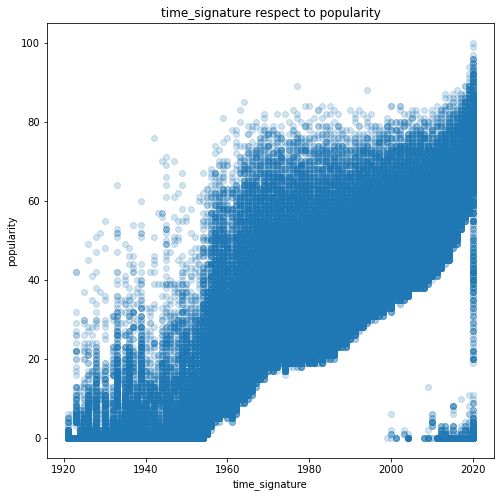

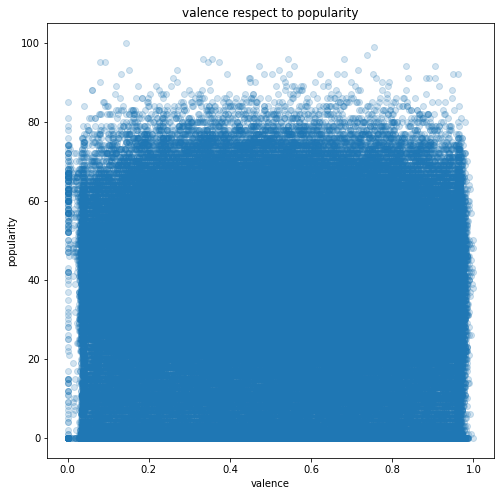

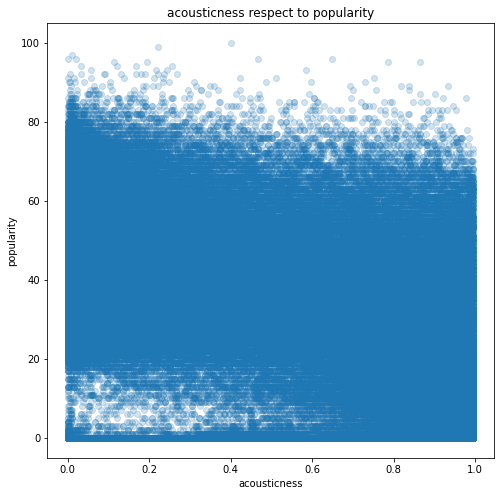

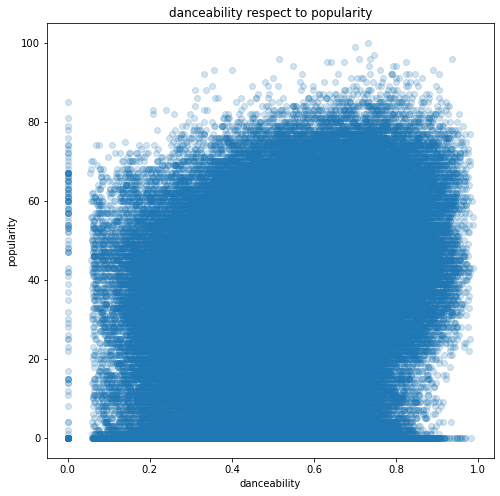

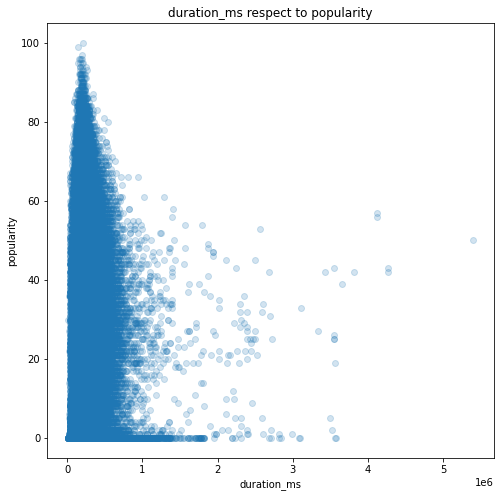

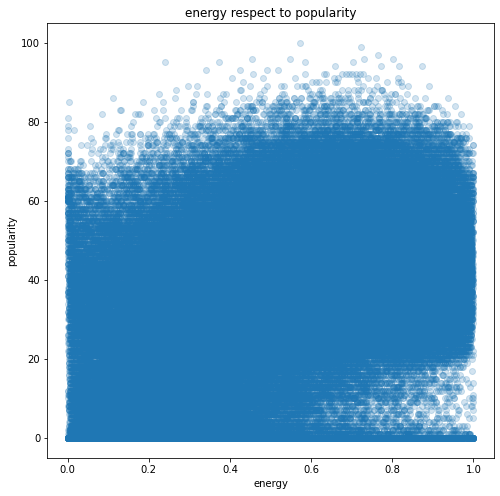

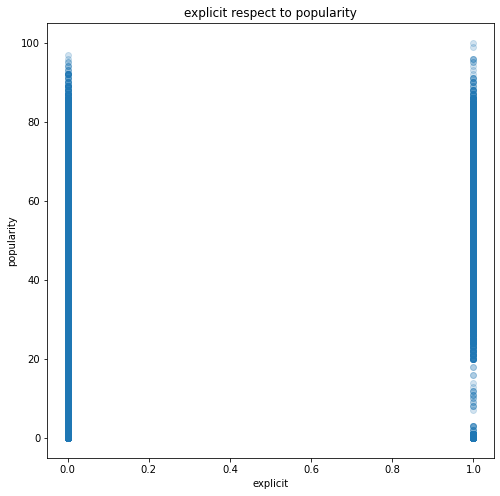

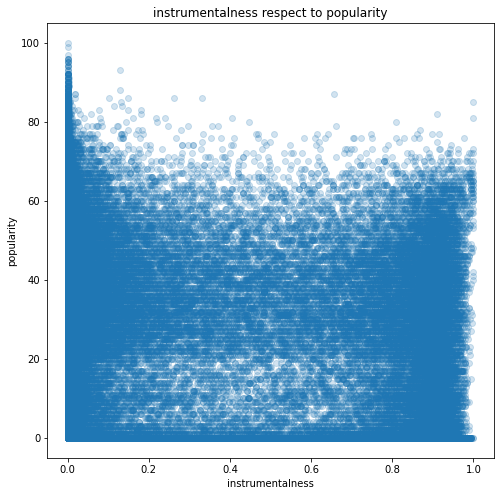

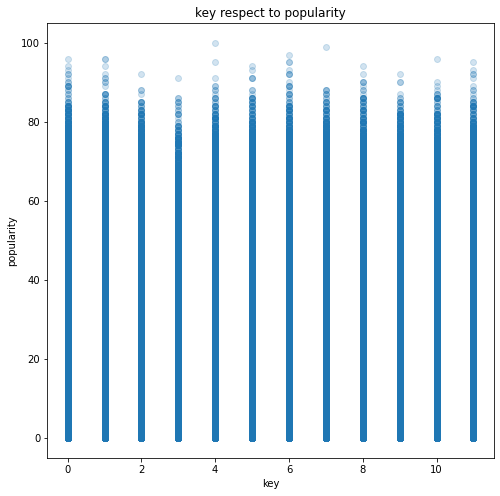

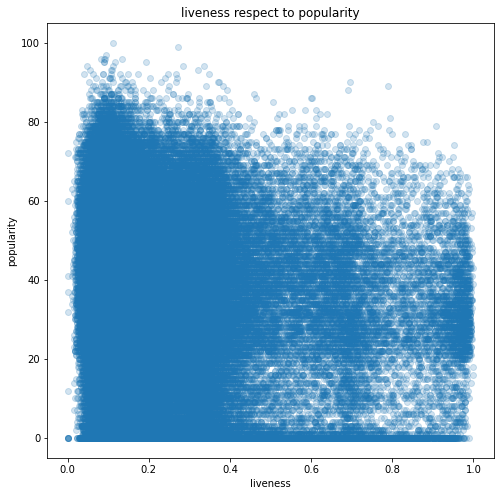

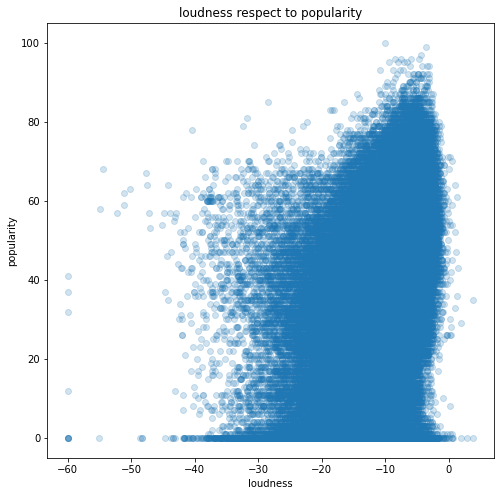

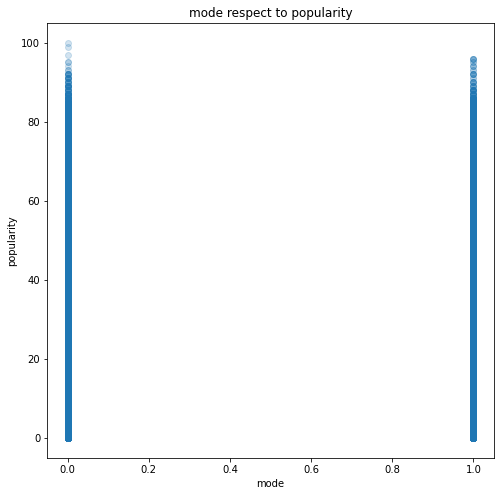

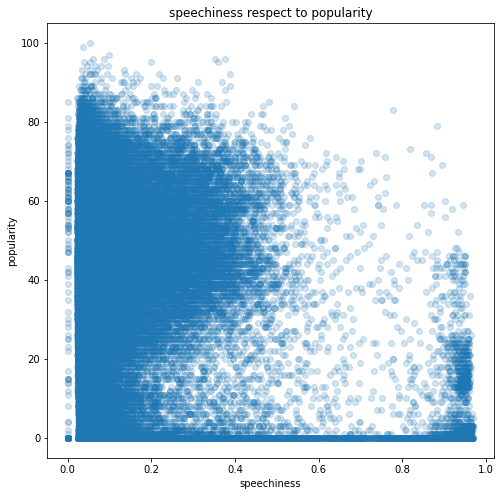

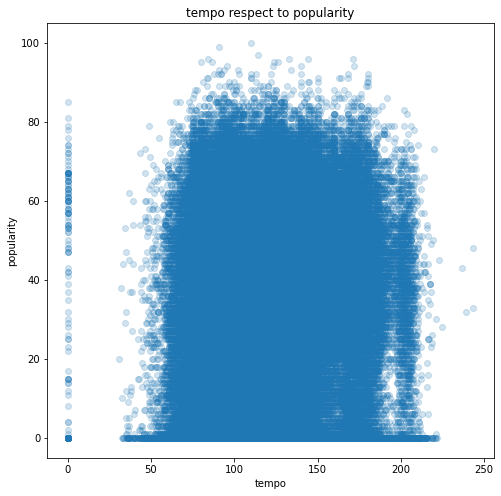

In [26]:
for col in df.drop(columns='popularity').columns:
    scatter_plot(df,col,'popularity')

Time_signature to popularity does seem to have a higher correlation in this visualization. other wise, we can try to do a logistic relationship between popularity and explicit, popularity and mode.multi class labeling between popularity and key can also be considered

### Undersample process

/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


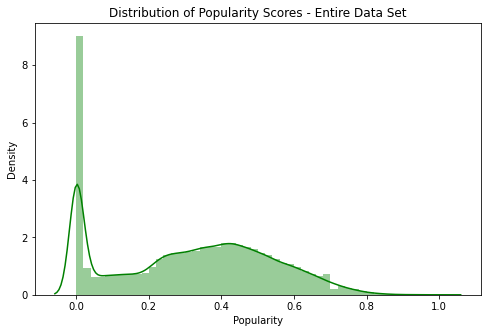

In [27]:
# plot polularity scores distribution
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity']/100, color='g', label="Popularity").set_title("Distribution of Popularity Scores - Entire Data Set")

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()
    
plot_pop_dist(df)

we have a betterly distributed popularity scores.Not ideal, though the popularity scores on the fringe of 0.0 may require specific decisions

Possible approach to undersample data to improve regression modeling validating

Mean value for Danceability feature for Popular songs: 0.6905972222222224
Mean value for Danceability feature for Unpopular songs: 0.5372193182018234


/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


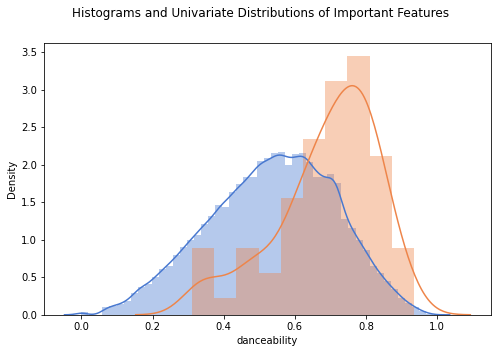

/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


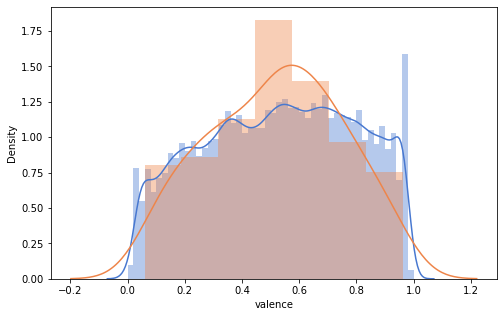

/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


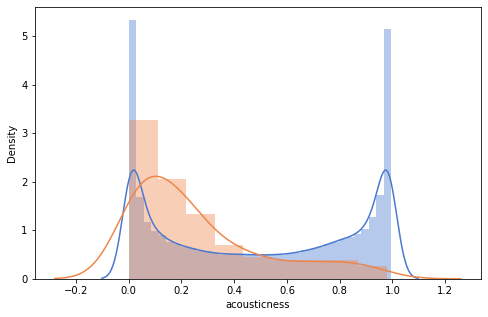

In [28]:
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for Danceability feature for Popular songs: {}'.format(df[df['popularity'] > popularity_cutoff]['danceability'].mean()))
    print('Mean value for Danceability feature for Unpopular songs: {}'.format(df[df['popularity'] < popularity_cutoff]['danceability'].mean()))
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity'] < popularity_cutoff]['danceability'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['danceability'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity'] < popularity_cutoff]['valence'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['valence'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity'] < popularity_cutoff]['acousticness'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['acousticness'])
    plt.show()

plot_univ_dists(df, 85)

valence feature seems very well distributed at cutoff . otherwise it seems danceability takes up the larger portion of higher popularity scores and acousticness on the lower end of popularity scores

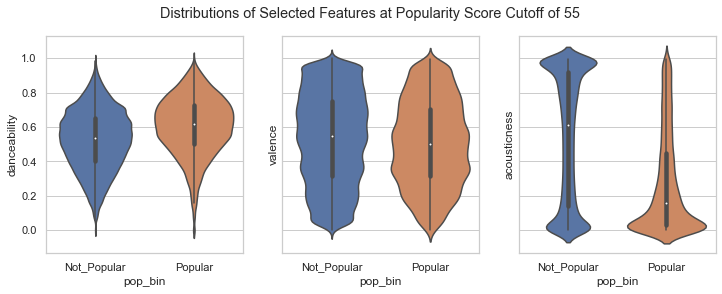

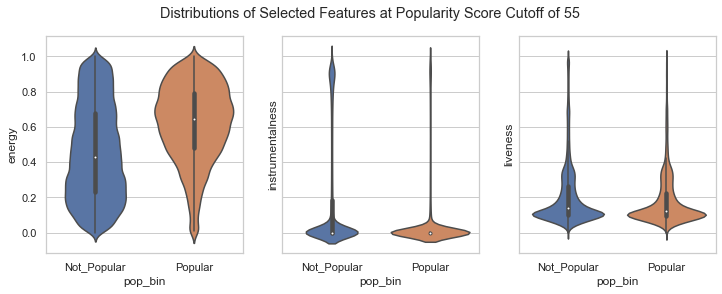

In [29]:
def plot_violin(df, cutoff):
    df = df.copy()
    
    sns.set(style="whitegrid")
    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")
    
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of 55')
    
    sns.violinplot(x=df['pop_bin'], y=df['danceability'], ax=ax[0])
    sns.violinplot(x=df['pop_bin'], y=df['valence'], ax=ax[1])
    sns.violinplot(x=df['pop_bin'], y=df['acousticness'], ax=ax[2])
    
    plt.show()

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of 55')

    sns.violinplot(x=df['pop_bin'], y=df['energy'], ax=ax[0])
    sns.violinplot(x=df['pop_bin'], y=df['instrumentalness'], ax=ax[1])
    sns.violinplot(x=df['pop_bin'], y=df['liveness'], ax=ax[2])
    
    plt.show()
plot_violin(df, 55)

These violin plots reinforce the insights from the univariate plots but namely energy seems to have less relationship with popularity with cutoff at 55

/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


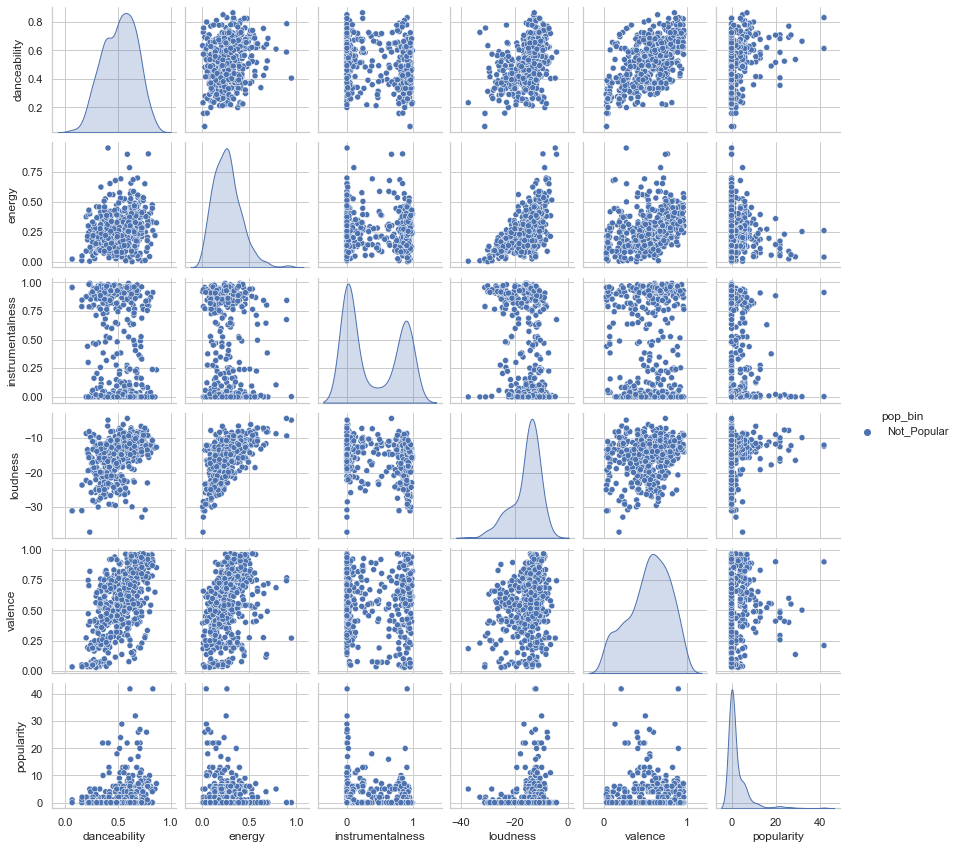

In [30]:
# plot pairplot for subsection of df rows and columns
def plot_pairplot(df, rows, cutoff):
    # not it looks MUCH better to run this function in jupyter
    df = df.copy()
    
    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")
    
    cols_for_pp = ['danceability', 'energy', 'instrumentalness',
       'loudness','valence', 'popularity', 'pop_bin']

    sns.pairplot(df.loc[:rows, cols_for_pp], hue='pop_bin', size=2)

    plt.show()
plot_pairplot(df, 500, 55)


pairplot for subsection of df rows and columns. Our data does seems to have inter feature relationships with each other.

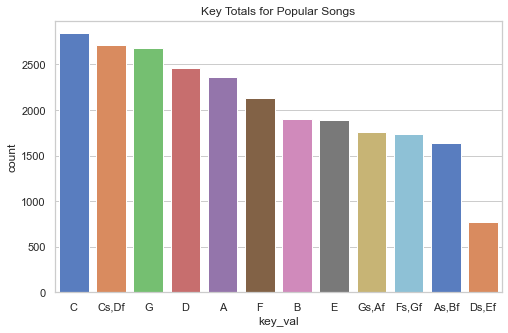

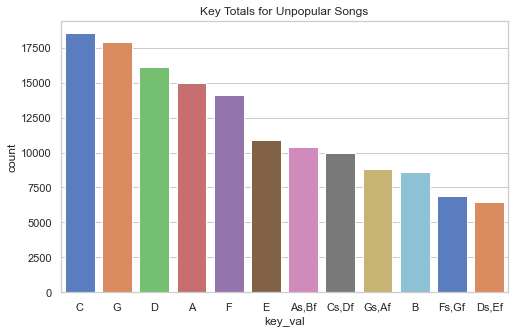

In [31]:
# plot the key counts for popular and unpopular songs
def plot_keys(df, cutoff):
    df_popular = df[df['popularity'] > cutoff].copy()
    
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,5))
    key_mapping = {0.0: 'C', 1.0: 'Cs,Df', 2.0: 'D', 3.0: 'Ds,Ef', 4.0: 'E', 5.0: 
                  'F', 6.0: 'Fs,Gf', 7.0: 'G', 8.0: 'Gs,Af', 9.0: 'A', 10.0: 'As,Bf', 
                  11.0: 'B'}
    
    df_popular['key_val'] = df_popular['key'].map(key_mapping)
    sns.countplot(x='key_val', data=df_popular, order=df_popular['key_val'].value_counts().index, palette='muted')
    plt.title("Key Totals for Popular Songs")
    plt.show()

    df_unpopular = df[df['popularity'] < 55].copy()
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,5))
    df_unpopular['key_val'] = df_unpopular['key'].map(key_mapping)
    sns.countplot(x='key_val', data=df_unpopular, order=df_unpopular['key_val'].value_counts().index, palette='muted')
    plt.title("Key Totals for Unpopular Songs")
    plt.show()
plot_keys(df, 55)

key counts for popular and unpopular songs by arbitray cutoff

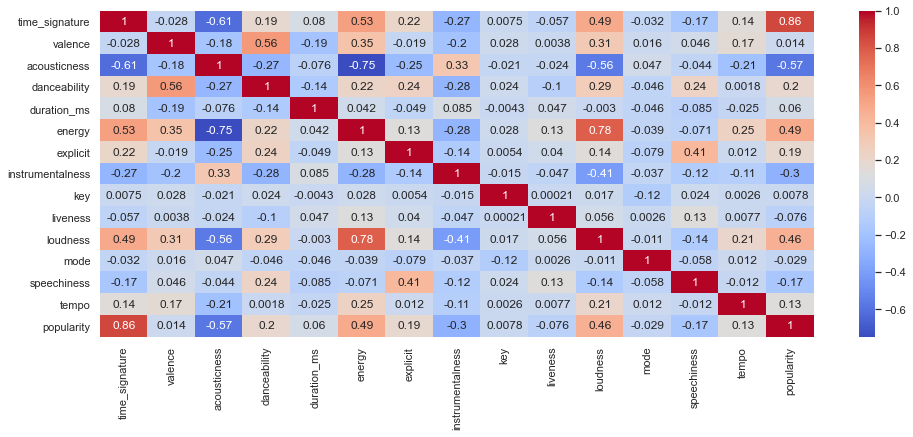

In [32]:
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
plot_heatmap(df)

heat map of data frame at large


## Initial linear regression Analysis, and plots
- regression on train for analysis

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 2.977e+04
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:11:53   Log-Likelihood:            -4.8721e+05
No. Observations:              127989   AIC:                         9.745e+05
Df Residuals:                  127975   BIC:                         9.746e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1288.0807      3.331  

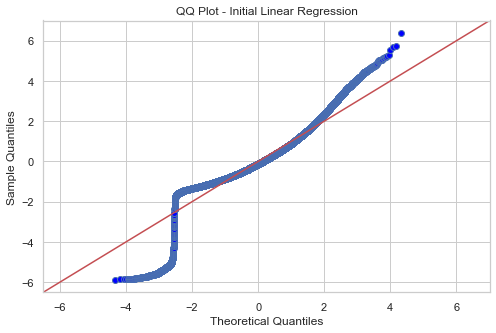

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


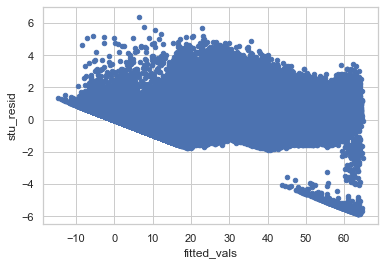

In [33]:
# initial linear regression function, and plots
def linear_regression_initial(df):
    df = df.copy()

    X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
          'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
          'speechiness', 'tempo', 'time_signature', 'valence']

    y_col = ['popularity']
    
    X = df[X_cols]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    X_train = sm.add_constant(X_train)

    # Instantiate OLS model, fit, predict, get errors
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    fitted_vals = results.predict(X_train)
    
    stu_resid = results.resid_pearson
    residuals = results.resid
    y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                           'stu_resid': stu_resid})

    # Print the results
    print(results.summary())
    
    # train test relationship plot
#     Xy_scatter_plot(y_train,fitted_vals)

    # QQ Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.title("QQ Plot - Initial Linear Regression")
    fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
    plt.show()

    # Residuals Plot
    y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
    plt.show()

linear_regression_initial(df)

naive regression on feature vectors with respect to popularity produces an acceptable R2 score. this seems to be largely due to the labeled columns of time_signature(year, 0.671 coefficient coverage) to each song entry. undersample can be explored to see if modeling of data can be improved.

there seems to be a potential implication where the jarque bera (JB) score is very high. an ordinary least squares regression assumes training data to be normally distributed. this high a JB score just means the bell curve bell is very steep and sharp and not regressed on a normal distribution. possible solutions is to engineer or adjust the data via a white test or a Heteroskedasticity test to determine the beta coefficients to centre for.

# Undersampling Analysis

/home/pysolver33/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


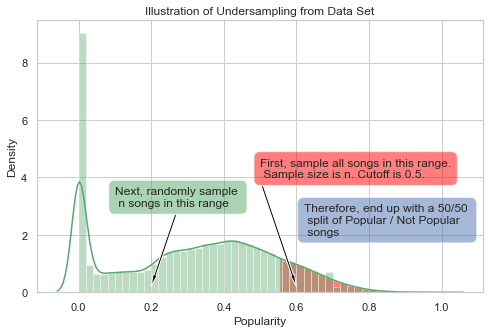

In [34]:
# plot undersampling methodology
def undersample_plot(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")
    
    # create line to shade to the right of
    line = ax.get_lines()[-1]
    x_line, y_line = line.get_data()
    mask = x_line > 0.55
    x_line, y_line = x_line[mask], y_line[mask]
    ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

    # get values for and plot first label
    label_x = 0.5
    label_y = 4
    arrow_x = 0.6
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "First, sample all songs in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=arrow_properties)

    # Get values for and plot second label
    label_x = 0.1
    label_y = 3
    arrow_x = 0.2
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "Next, randomly sample \n n songs in this range", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
        arrowprops=arrow_properties)

    # plot final word box
    plt.annotate(
        "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n songs", xy=(0.6, 2),
        xytext=(0.62, 2),
        bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

undersample_plot(df)

In [35]:
# check that deltas in means are significant for selected dependent variables
def calc_ANOVA(df, cutoff):
    df_popular = df[df['popularity'] > cutoff].copy()
    df_unpopular = df[df['popularity'] < cutoff].copy()

    print("Popular and Unpopular Danceability Means:")  
    print(df_popular['danceability'].mean())
    print(df_unpopular['danceability'].mean())
    f_val, p_val = stats.f_oneway(df_popular['danceability'], df_unpopular['danceability'])  
    
    print("Danceability One-way ANOVA P ={}".format(p_val)) 

    print("Popular and Unpopular Loudness Means:")  
    print(df_popular['loudness'].mean())
    print(df_unpopular['loudness'].mean())
    f_val, p_val = stats.f_oneway(df_popular['loudness'], df_unpopular['loudness'])  
    
    print("Loudness One-way ANOVA P ={}".format(p_val)) 

    print(df_popular['valence'].mean())
    print(df_unpopular['valence'].mean())
    f_val, p_val = stats.f_oneway(df_popular['valence'], df_unpopular['valence'])  
    
    print("Valence One-way ANOVA P ={}".format(p_val))

    print(df_popular['instrumentalness'].mean())
    print(df_unpopular['instrumentalness'].mean())
    f_val, p_val = stats.f_oneway(df_popular['instrumentalness'], df_unpopular['instrumentalness'])  
    
    print("Instrumentalness One-way ANOVA P ={}".format(p_val))
calc_ANOVA(df, 55)

Popular and Unpopular Danceability Means:
0.6064569994781015
0.5249966798220962
Danceability One-way ANOVA P =0.0
Popular and Unpopular Loudness Means:
-7.818141916576323
-12.143908176547047
Loudness One-way ANOVA P =0.0
0.5073261942269836
0.5324745712731527
Valence One-way ANOVA P =4.611725345656175e-44
0.05780661045887044
0.18705228204402824
Instrumentalness One-way ANOVA P =0.0


check that deltas in means are significant for selected dependent variables

### The F Statistic and P Value
The F statistic must be used in combination with the p value when you are deciding if your overall results are significant. Why? If you have a significant result, it doesn’t mean that all your variables are significant. The statistic is just comparing the joint effect of all the variables together.

For example, if you are using the F Statistic in regression analysis (perhaps for a change in R Squared, the Coefficient of Determination), you would use the p value to get the “big picture.”

- If the p value is less than the alpha level, go to Step 2 (otherwise your results are not significant and you cannot reject the null hypothesis). A common alpha level for tests is 0.05.
- Study the individual p values to find out which of the individual variables are statistically significant.

https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/


In [36]:
def random_under_sampler(df, cutoff):
    df_original = df.copy()
    df_original['pop_bin'] = np.where(df_original['popularity'] > cutoff, "Popular", "Not_Popular")

    df_small = df_original[df_original['popularity'] > cutoff].copy()
    df_samples_added = df_small.copy()
    
    total = df_small.shape[0] + 1

    # loop through and add random unpopular rows to sampled df
    while total <= df_small.shape[0]*2:

        # pick a random from from the original dataframe
        rand_row = random.randint(0,df_original.shape[0])
        
        if df_original.loc[rand_row, 'pop_bin'] == "Not_Popular":
            df_samples_added.loc[total] = df_original.loc[rand_row, :]
            total +=1

    # print some stats on the undersampled df
    print("Size checks for new df:")
    print("Shape of new undersampled df: {}".format(df_samples_added.shape))
    print(df_samples_added['pop_bin'].value_counts())
    print(df_samples_added[df_samples_added['pop_bin'] == 'Popular']['danceability'].mean())
    print(df_samples_added[df_samples_added['pop_bin'] == 'Not_Popular']['danceability'].mean())
    print(df_samples_added[df_samples_added['pop_bin'] == 'Popular']['danceability'].count())
    print(df_samples_added[df_samples_added['pop_bin'] == 'Not_Popular']['danceability'].count())
    f_val, p_val = stats.f_oneway(df_samples_added[df_samples_added['pop_bin'] == 'Popular']['danceability'], df_samples_added[df_samples_added['pop_bin'] == 'Not_Popular']['danceability'])  
  
    print("One-way ANOVA P ={}".format(p_val))

    # return the df
    return df_samples_added

df_samples = random_under_sampler(df, 80)
df_samples

Size checks for new df:
Shape of new undersampled df: (1098, 16)
Not_Popular    549
Popular        549
Name: pop_bin, dtype: int64
0.6781930783242262
0.5293557377049175
549
549
One-way ANOVA P =2.730428983762659e-48


,time_signature,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity,pop_bin
7406,1959,0.7010,0.91200,0.451,117147,0.240,0,0.000002,1,0.1750,-14.014,1,0.0351,134.009,81,Popular
8206,1963,0.7760,0.76600,0.240,151933,0.598,0,0.000000,7,0.1170,-8.435,1,0.0369,201.629,83,Popular
8406,1964,0.8980,0.61400,0.589,126267,0.472,0,0.000000,8,0.5050,-8.749,1,0.0502,67.196,85,Popular
9406,1969,0.6630,0.20100,0.640,140773,0.663,0,0.008060,0,0.1520,-7.516,1,0.0374,132.770,81,Popular
9407,1969,0.3940,0.03390,0.557,185733,0.540,0,0.002480,9,0.1790,-10.484,1,0.0347,129.171,82,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,1938,0.7450,0.99400,0.695,165107,0.358,0,0.650000,6,0.1280,-9.950,1,0.0880,126.837,0,Not_Popular
1095,2010,0.9450,0.51400,0.598,126120,0.932,0,0.000000,7,0.3500,-2.534,1,0.0934,170.048,51,Not_Popular
1096,2004,0.0863,0.00903,0.602,235200,0.847,0,0.030600,9,0.0622,-5.998,0,0.0589,138.025,59,Not_Popular
1097,1970,0.3660,0.02120,0.398,408257,0.632,0,0.879000,10,0.2650,-12.854,0,0.0882,169.366,26,Not_Popular


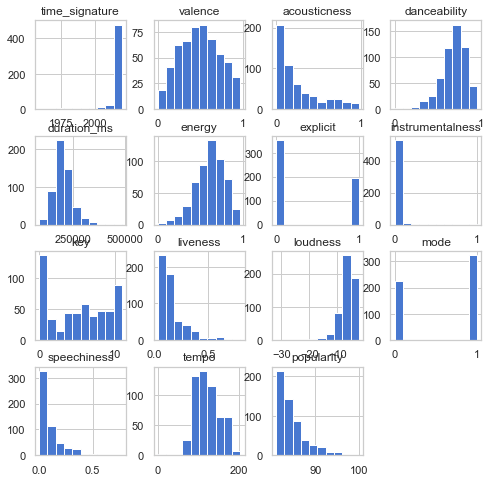

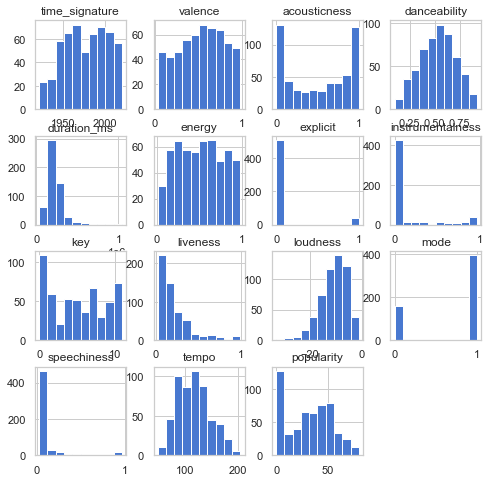

In [37]:
# plot histograms of metrics for popular and unpopular songs
def plot_hist(sampled_df):
    sampled_df[sampled_df['pop_bin'] == "Popular"].hist(figsize=(8, 8))  
    plt.show()

    sampled_df[sampled_df['pop_bin'] != "Popular"].hist(figsize=(8, 8))
    plt.show()
    
plot_hist(df_samples)

First histograms are for popular labeled entries for under sampled data. Second histogram for unpopular labeled entries for under sampled data. 
- Popular songs tend to be more recent. 
- Valence is normally distributed.
- minamal acousticness with popular entries
- slightly more danceable with popular entires
- duration of unpopular songs are distinctly longer
- popular entries energy levels tend to be more normally distributed
- popular songs tend to be less loud

## Undersampled Regression Analysis

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     339.0
Date:                Sat, 13 Feb 2021   Prob (F-statistic):          1.32e-316
Time:                        00:12:04   Log-Likelihood:                -3217.8
No. Observations:                 823   AIC:                             6464.
Df Residuals:                     809   BIC:                             6530.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1780.9389     49.465  

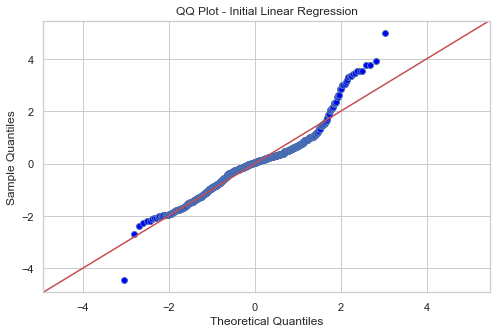

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


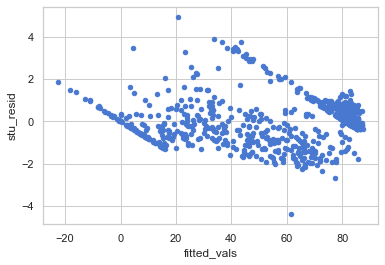

In [38]:
linear_regression_initial(df_samples)

after undersampling the data, the R2 score of the regression model has significantly improved. previous test removals of popularity scores that are 0 lowers the R2 score which implies that the 0 popularity scores has significant weights on the regression model of our data. Random undersampling of popular and unpopular data at 0.5 cutoff for 50/50 evenly divided data also nicely normally distributed our data, reducing JB value significantly

## Final Regression Analysis
- haven improved our regression model with random distribution of 50/50 popular by unpopular entries we can then proceed to standardize certain features that affect the Jarque-Bera score of our initial regression analysis and run regression again.

In [39]:
# choose cutoff, sample popular data, randomly sample unpopular data, and combine the dfs
def split_sample_combine(df, cutoff=55, col='popularity', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] > cutoff].copy()
    
    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] < cutoff].copy()
    
    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]
    
    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add key_notes mapping key num vals to notes
    key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 
                   4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 
                   8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
    ssc_df['key_notes'] = ssc_df['key'].map(key_mapping)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df['popularity'] / 100
    ssc_df['pop_cat'] = np.where(ssc_df['popularity'] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df['popularity'] > cutoff, 1, 0)
    
    return ssc_df

df_split = split_sample_combine(df, cutoff=65, rand=0)
df_split

,time_signature,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity,key_notes,pop_frac,pop_cat,pop_bin
0,1946,0.1260,0.9960,0.356,95173,0.022400,0,0.942000,0,0.119,-27.039,1,0.0409,66.001,4,C,0.04,Not_Popular,0
1,1962,0.6580,0.8420,0.505,142307,0.449000,0,0.002590,2,0.217,-9.777,1,0.0257,106.193,15,D,0.15,Not_Popular,0
2,2016,0.0386,0.9570,0.157,119406,0.000553,0,0.919000,0,0.106,-38.094,1,0.0482,69.712,60,C,0.60,Not_Popular,0
3,2007,0.7750,0.0164,0.724,332733,0.853000,1,0.000000,11,0.650,-3.895,0,0.2830,170.510,69,B,0.69,Popular,1
4,2005,0.2980,0.8720,0.656,232533,0.291000,0,0.000000,2,0.114,-10.572,1,0.0293,103.971,81,D,0.81,Popular,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17821,1997,0.3250,0.5490,0.517,510307,0.503000,0,0.436000,0,0.110,-12.202,1,0.0313,127.079,33,C,0.33,Not_Popular,0
17822,2003,0.3840,0.0912,0.795,186867,0.891000,0,0.000000,0,0.332,-4.124,1,0.1890,95.031,44,C,0.44,Not_Popular,0
17823,1962,0.4450,0.8670,0.397,191227,0.275000,0,0.000000,4,0.188,-10.646,1,0.0352,151.657,18,E,0.18,Not_Popular,0
17824,1945,0.4780,0.1990,0.717,95600,0.189000,1,0.000002,1,0.140,-20.121,1,0.9330,126.017,0,"C♯,D♭",0.00,Not_Popular,0


#### Steps
- choose cutoff, sample popular data, randomly sample unpopular data, and combine the dfs
- split out popular rows above the popularity cutoff
- get the leftover rows, the 'unpopular' songs
- what % of the original data do we now have? 
- what % of leftover rows do we need?
- get the exact # of unpopular rows needed, using a random sampler
- combine the dataframes to get total rows = split_pop_df * 2
- shuffle the df
- add key_notes mapping key num vals to notes
- add columns relating to popularity

In [40]:
# final, clean, linear regression function
def linear_regression_final(df, show_plots=True):
    X, y = standardize_return_X_y(df, std=True, log=False)

    # Add constant
    X = sm.add_constant(X)

    # Instantiate OLS model, fit, predict, and get errors
    model = sm.OLS(y, X)
    results = model.fit()
    fitted_vals = results.predict(X)
    stu_resid = results.resid_pearson
    residuals = results.resid
    y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                           'stu_resid': stu_resid})

    # Maybe do a line graph for this?
    print(results.summary())
    
    ### Plot predicted values vs. actual/true
    if show_plots == True:
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title("True vs. Predicted Popularity Values - Initial Linear Regression")
        plt.plot(y,alpha=0.2, label="True")
        plt.plot(fitted_vals,alpha=0.5, c='r', label="Predicted")
        plt.ylabel("Popularity")
        plt.legend()
        plt.show()
        # train test relationship plot
        Xy_scatter_plot(y,fitted_vals)

    # QQ Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
        plt.show()
  

    # Residuals Plot
        y_vals.plot(kind='scatter', y='fitted_vals', x='stu_resid')
        plt.show()

    return results
linear_regression_final(df_split, show_plots=False)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     4296.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:12:05   Log-Likelihood:                -70593.
No. Observations:               17826   AIC:                         1.412e+05
Df Residuals:                   17812   BIC:                         1.413e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1425.5788     10.069  

after standardizing duration_ms,loudness,tempo, the Jarque-Bera (JB) value improves alot indicating that our regression is now being performed on normally distributed data as it should. 

RMSE for training set 12.595707880767442
RMSE for test set 12.992578718932497
The Coefficients are:
[[-4.72459923  3.54037879  0.16251838 -0.29915324 -8.14089818 -0.0223004
  -4.04404871  0.53284717 -0.52393441 -9.71050621  0.12826405  0.7440073
   0.48541529]]
The R^2 values is: 0.7609587710846266


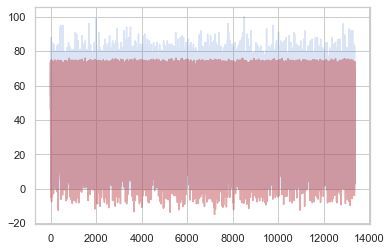

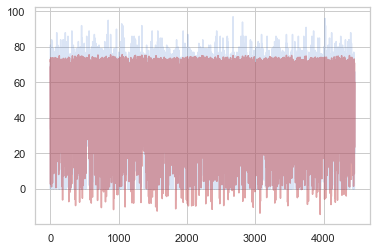

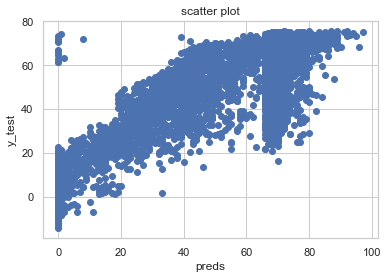

In [41]:
def my_rmse(y_true, y_pred):
    mse = ((y_true - y_pred)**2).mean()
    return np.sqrt(mse)
# create a linear regression using sklearn, in order to compare models, and 
# also incorporate train_test_split into this, and calculate and print RMSE
def linear_regression_sklearn(df, show_plots=True):
    X, y = standardize_return_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Fit model using the training set
    linear = LinearRegression()
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate RMSE for training and test set
    print('RMSE for training set {}'.format(my_rmse(y_train.values, train_predicted)))
    print('RMSE for test set {}'.format(my_rmse(y_test.values, test_predicted)))
    print('The Coefficients are:')
    print(linear.coef_)
    print('The R^2 values is: {}'.format(linear.score(X_train, y_train)))

    if show_plots == True:
        plt.plot(y_train.reset_index(drop=True), alpha=0.2)
        plt.plot(train_predicted, alpha=0.5, c='r')
        plt.show()

        plt.plot(y_test.reset_index(drop=True), alpha=0.2)
        plt.plot(test_predicted, alpha=0.5, c='r')
        plt.show()    # train test relationship plot
        Xy_scatter_plot(y_test,test_predicted)
        
linear_regression_sklearn(df_split, show_plots=True)

Sklearn regression of standardized data of features duration_ms,loudness,tempo with RMSE score and R2 score

RMSE for training set 12.722711603606706
RMSE for test set 12.199393197300836
The Coefficients are:
[[-4.74552685e+00  9.26714904e+00 -1.16513557e+00 -1.59824295e+01
  -7.63906950e+00 -1.56428933e-02  1.93512437e+00  2.90504333e+00
  -1.95595121e-01 -5.34035282e+00  3.08284752e-01  9.19975368e-01
  -9.97340674e-01]]
The R^2 values is: 0.8311444686053044


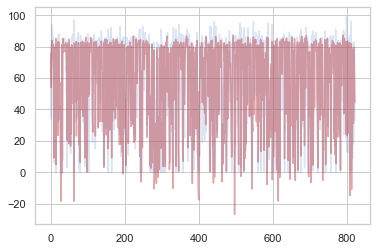

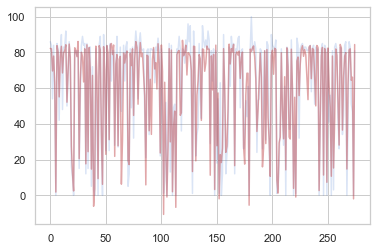

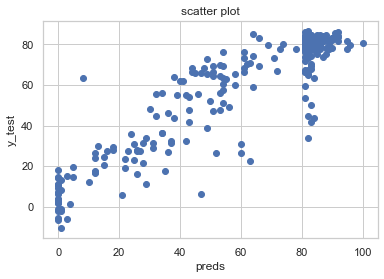

In [42]:
linear_regression_sklearn(df_samples, show_plots=True)

Sklearn regression of undersampled data with RMSE score and R2 score